# Tweet Analysis - Apple and Google

#### Author: Joseph Denney
#### Email: joseph.d.denney@gmail.com
#### github: www.github.com/josephdenney

## Introduction

### Problem and Purpose

## Table of Contents

1. Header, name, date, github link and email
2. introduction/business dilemma, spelling out purpose and what we are going to do in this project
3. clean up table of contents, organize
4. 3 recommendations required - two approaches. model centric recommendations. use the language to give recommendations to improve a potential phone product. 



## EDA and Data Preprocessing

### Library, function, and data imports

In [401]:
import numpy as np
import pandas as pd
import spacy
import re
import nltk
import matplotlib.pyplot as plt
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', 
                    level=logging.INFO)
from gensim.models import Word2Vec
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
import seaborn as sns

from nltk.stem.wordnet import WordNetLemmatizer
import string
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
from nltk import word_tokenize, FreqDist
from applesauce import model_scoring, cost_benefit_analysis, evaluate_model
from applesauce import model_opt, single_model_opt

from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_curve, f1_score, precision_score
from sklearn.metrics import recall_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier 
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.naive_bayes import BernoulliNB, CategoricalNB, GaussianNB 
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer 
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.utils import resample

from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\josep\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\josep\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\josep\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [402]:
nlp = spacy.load("en_core_web_sm")

In [403]:
print(stopwords)
print(nlp.Defaults.stop_words) 
# view list of stopwords

<WordListCorpusReader in 'C:\\Users\\josep\\AppData\\Roaming\\nltk_data\\corpora\\stopwords'>
{'now', 'formerly', '‘d', 'bottom', 'onto', 'due', 'someone', 'amongst', 'can', 'wherever', 'an', 'toward', 'ca', 'alone', 'nothing', 'where', 'however', 'and', 'six', 'without', "'d", 'am', 'me', 'when', '’s', 'their', 'beforehand', 'enough', 'around', 'amount', 'from', 're', 'somehow', 'noone', 'that', 'have', 'so', 'throughout', 'how', 'just', "'re", 'eight', 'others', 'with', '’re', 'full', 'between', 'seems', 'could', 'cannot', 'next', 'be', 'thence', 'empty', 'its', 'had', 'hereupon', 'anyhow', 'nowhere', 'been', 'anywhere', 'twelve', 'these', 'as', 'of', 'more', 'whereby', 'this', 'otherwise', 'still', 'everywhere', 'well', 'myself', 'anything', 'was', 'here', 'mostly', 'several', 'afterwards', 'least', 'seemed', '‘re', 'regarding', 'then', 'through', 'because', 'i', 'beside', 'part', 'most', 'yours', 'should', 'two', 'her', 'become', 'itself', 'back', 'may', 'unless', 'though', 'therea

In [404]:
df = pd.read_csv('data/product_tweets.csv',encoding='latin1')

In [405]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [406]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [407]:
df['emotion_in_tweet_is_directed_at'].unique()

array(['iPhone', 'iPad or iPhone App', 'iPad', 'Google', nan, 'Android',
       'Apple', 'Android App', 'Other Google product or service',
       'Other Apple product or service'], dtype=object)

In [408]:
df['emotion_in_tweet_is_directed_at'].count()

3291

### Data Exploration and Column Title Cleanup

In [409]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].unique()

array(['Negative emotion', 'Positive emotion',
       'No emotion toward brand or product', "I can't tell"], dtype=object)

In [410]:
df = df.rename(columns= {'is_there_an_emotion_directed_at_a_brand_or_product'
                         :'Emotion',
                         'emotion_in_tweet_is_directed_at': 'Platform'})

In [411]:
df = df.rename(columns= {'tweet_text': 'Tweet'})

In [412]:
df.head() 

,Tweet,Platform,Emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [413]:
df.groupby(df['Platform']).count()

,Tweet,Emotion
Platform,,
Android,78,78
Android App,81,81
Apple,661,661
Google,430,430
Other Apple product or service,35,35
Other Google product or service,293,293
iPad,946,946
iPad or iPhone App,470,470
iPhone,297,297


### Dummify Target Column

In [414]:
df_dummify = pd.get_dummies(df['Emotion'])

In [415]:
df_dummify.head()

,I can't tell,Negative emotion,No emotion toward brand or product,Positive emotion
0,0,1,0,0
1,0,0,0,1
2,0,0,0,1
3,0,1,0,0
4,0,0,0,1


In [416]:
df_dummify.sum() # class bias 

I can't tell                           156
Negative emotion                       570
No emotion toward brand or product    5389
Positive emotion                      2978
dtype: int64

In [417]:
df.info()
df = pd.merge(df, df_dummify, how='outer',on=df.index) 
# ran this code, dummify emotion data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Tweet     9092 non-null   object
 1   Platform  3291 non-null   object
 2   Emotion   9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [418]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9093 entries, 0 to 9092
Data columns (total 8 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   key_0                               9093 non-null   int64 
 1   Tweet                               9092 non-null   object
 2   Platform                            3291 non-null   object
 3   Emotion                             9093 non-null   object
 4   I can't tell                        9093 non-null   uint8 
 5   Negative emotion                    9093 non-null   uint8 
 6   No emotion toward brand or product  9093 non-null   uint8 
 7   Positive emotion                    9093 non-null   uint8 
dtypes: int64(1), object(3), uint8(4)
memory usage: 390.7+ KB


In [419]:
df.head()

,key_0,Tweet,Platform,Emotion,I can't tell,Negative emotion,No emotion toward brand or product,Positive emotion
0,0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,0,1,0,0
1,1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,0,0,0,1
2,2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,0,0,0,1
3,3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,0,1,0,0
4,4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,0,0,0,1


In [420]:
df = df.rename(columns = {"I can't tell": "Uncertain", 
                          'Negative emotion': 'Negative', 
                          'No emotion toward brand or product': 'No Emotion',
                          'Positive emotion':'Positive'})

In [421]:
df = df.drop(columns='key_0')
df.head()
df.to_csv('Full_DF')

In [422]:
corpus = list(df['Tweet']) # verify corpus list
corpus[:10]

['.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.',
 "@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",
 '@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.',
 "@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw",
 "@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",
 '@teachntech00 New iPad Apps For #SpeechTherapy And Communication Are Showcased At The #SXSW Conference http://ht.ly/49n4M #iear #edchat #asd',
 nan,
 '#SXSW is just starting, #CTIA is around the corner and #googleio is only a hop skip and a jump from there, good time to be an #android fan',
 'Beautifully smart and simple idea RT @madebymany @thenextweb wrote about our #hollergram iPad app for #sxsw! http://bit.l

### Platform Negative Incidence Table

In [423]:
df.groupby(by=df['Platform']).sum()

,Uncertain,Negative,No Emotion,Positive
Platform,,,,
Android,0.0,8.0,1.0,69.0
Android App,0.0,8.0,1.0,72.0
Apple,2.0,95.0,21.0,543.0
Google,1.0,68.0,15.0,346.0
Other Apple product or service,0.0,2.0,1.0,32.0
Other Google product or service,1.0,47.0,9.0,236.0
iPad,4.0,125.0,24.0,793.0
iPad or iPhone App,0.0,63.0,10.0,397.0
iPhone,1.0,103.0,9.0,184.0


### Tokenize and Create Bag of Words

In [522]:
tokenz = word_tokenize(','.join(str(v) for v in corpus))

In [425]:
tokenz[:10]

['.', '@', 'wesley83', 'I', 'have', 'a', '3G', 'iPhone', '.', 'After']

### Create Stopwords List

In [426]:
stopword_list = list(nlp.Defaults.stop_words)
len(nlp.Defaults.stop_words)

326

In [427]:
stopword_list

['now',
 'formerly',
 '‘d',
 'bottom',
 'onto',
 'due',
 'someone',
 'amongst',
 'can',
 'wherever',
 'an',
 'toward',
 'ca',
 'alone',
 'nothing',
 'where',
 'however',
 'and',
 'six',
 'without',
 "'d",
 'am',
 'me',
 'when',
 '’s',
 'their',
 'beforehand',
 'enough',
 'around',
 'amount',
 'from',
 're',
 'somehow',
 'noone',
 'that',
 'have',
 'so',
 'throughout',
 'how',
 'just',
 "'re",
 'eight',
 'others',
 'with',
 '’re',
 'full',
 'between',
 'seems',
 'could',
 'cannot',
 'next',
 'be',
 'thence',
 'empty',
 'its',
 'had',
 'hereupon',
 'anyhow',
 'nowhere',
 'been',
 'anywhere',
 'twelve',
 'these',
 'as',
 'of',
 'more',
 'whereby',
 'this',
 'otherwise',
 'still',
 'everywhere',
 'well',
 'myself',
 'anything',
 'was',
 'here',
 'mostly',
 'several',
 'afterwards',
 'least',
 'seemed',
 '‘re',
 'regarding',
 'then',
 'through',
 'because',
 'i',
 'beside',
 'part',
 'most',
 'yours',
 'should',
 'two',
 'her',
 'become',
 'itself',
 'back',
 'may',
 'unless',
 'though',
 '

In [428]:
stopword_list.extend(string.punctuation)

In [429]:
len(stopword_list)

358

In [430]:
stopword_list.extend(stopwords.words('english'))

In [431]:
len(stopword_list)

537

In [432]:
additional_punc = ['“','”','...',"''",'’','``','https','rt','\.+']
stopword_list.extend(additional_punc)
stopword_list[-10:]

["wouldn't", '“', '”', '...', "''", '’', '``', 'https', 'rt', '\\.+']

### Remove Stopwords and Additional Punctuation from the Data

In [433]:
stopped_tokenz = [word.lower() for word in tokenz if word.lower() 
                  not in stopword_list]

In [434]:
freq = FreqDist(stopped_tokenz)
freq.most_common(50)

[('sxsw', 9418),
 ('mention', 7120),
 ('link', 4313),
 ('google', 2593),
 ('ipad', 2432),
 ('apple', 2301),
 ('quot', 1696),
 ('iphone', 1516),
 ('store', 1472),
 ('2', 1114),
 ('new', 1090),
 ('austin', 959),
 ('amp', 836),
 ('app', 810),
 ('circles', 658),
 ('launch', 653),
 ('social', 647),
 ('android', 574),
 ('today', 574),
 ('network', 465),
 ('ipad2', 457),
 ('pop-up', 420),
 ('line', 405),
 ('free', 387),
 ('called', 361),
 ('party', 346),
 ('sxswi', 340),
 ('mobile', 338),
 ('major', 301),
 ('like', 290),
 ('time', 271),
 ('temporary', 264),
 ('opening', 257),
 ('possibly', 240),
 ('people', 226),
 ('downtown', 225),
 ('apps', 224),
 ('great', 222),
 ('maps', 219),
 ('going', 217),
 ('check', 216),
 ('mayer', 214),
 ('day', 214),
 ('open', 210),
 ('popup', 209),
 ('need', 205),
 ('marissa', 189),
 ('got', 185),
 ('w/', 182),
 ('know', 180)]

### Lemmatize the Data and use Regex to find and remove URL's, Tags, other misc

In [435]:
additional_misc = ['sxsw','mention',r'[a-zA-Z]+\'?s]',
                   r"(http[s]?://\w*\.\w*/+\w+)", r'\#\w*', 
                   r'RT [@]?\w*:', r'\@\w*',r"\d$",r"^\d",
                   r"([a-zA-Z]+(?:'[a-z]+)?)",r'\d.',r'\d','RT',
                   r'^http[s]?','za'] #[A-Z]{2,20} remove caps like MAGA and CDT
stopword_list.extend(additional_misc)
stopword_list.extend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

In [436]:
lemmatizer = WordNetLemmatizer()

In [437]:
clean_stopped_tokenz = [word.lower() for word in stopped_tokenz if word 
                        not in stopword_list]
clean_lemmatized_tokenz = [lemmatizer.lemmatize(word.lower()) for word 
                           in stopped_tokenz if word not in stopword_list]

In [438]:
freq_clean_lemma = FreqDist(clean_lemmatized_tokenz)
freq_lemma = freq_clean_lemma.most_common(5000)
freq_lemma2 = freq_clean_lemma.most_common(25)

In [439]:
total_word_count = len(clean_lemmatized_tokenz)

In [440]:
lemma_word_count = sum(freq_clean_lemma.values()) # just a number

In [441]:
for word in freq_lemma2: # separate both classes, positive and negative
    normalized_freq = word[1] / lemma_word_count
    print(word, "----", "{:.3f}".format(normalized_freq*100),"%")

('link', 4324) ---- 5.004 %
('google', 2594) ---- 3.002 %
('ipad', 2432) ---- 2.814 %
('apple', 2304) ---- 2.666 %
('quot', 1696) ---- 1.963 %
('iphone', 1516) ---- 1.754 %
('store', 1511) ---- 1.749 %
('new', 1090) ---- 1.261 %
('austin', 960) ---- 1.111 %
('amp', 836) ---- 0.967 %
('app', 810) ---- 0.937 %
('launch', 691) ---- 0.800 %
('circle', 673) ---- 0.779 %
('social', 647) ---- 0.749 %
('android', 574) ---- 0.664 %
('today', 574) ---- 0.664 %
('network', 473) ---- 0.547 %
('ipad2', 457) ---- 0.529 %
('line', 442) ---- 0.512 %
('pop-up', 422) ---- 0.488 %
('free', 387) ---- 0.448 %
('party', 386) ---- 0.447 %
('called', 361) ---- 0.418 %
('mobile', 340) ---- 0.393 %
('sxswi', 340) ---- 0.393 %


In [442]:
# from wordcloud import WordCloud

# ## Initalize a WordCloud with our stopwords_list and no bigrams
# wordcloud = WordCloud(stopwords=stopword_list,collocations=False)

# ## Generate wordcloud from stopped_tokens
# wordcloud.generate(','.join(clean_lemmatized_tokenz))

# ## Plot with matplotlib
# plt.figure(figsize = (12, 12), facecolor = None) 
# plt.imshow(wordcloud) 
# plt.axis('off')

In [443]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
tweet_finder = nltk.BigramCollocationFinder.from_words(clean_lemmatized_tokenz)
tweets_scored = tweet_finder.score_ngrams(bigram_measures.raw_freq)

In [444]:
word_pairs = pd.DataFrame(tweets_scored, columns=["Word","Freq"]).head(20)
word_pairs

,Word,Freq
0,"(apple, store)",0.006920
1,"(social, network)",0.005277
2,"(new, social)",0.004837
3,"(google, launch)",0.003912
4,"(link, google)",0.003877
5,"(network, called)",0.003784
6,"(called, circle)",0.003634
7,"(today, link)",0.003437
8,"(major, new)",0.003356
9,"(iphone, app)",0.003333


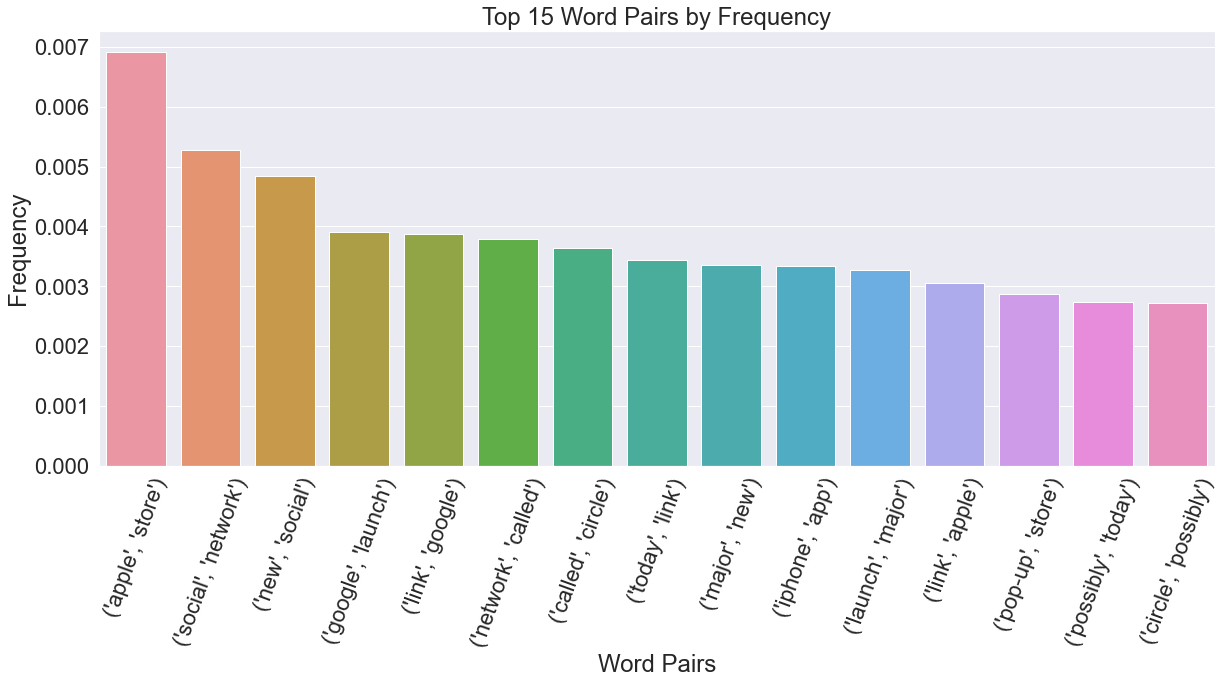

In [445]:
fig_dims = (20,8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.set(font_scale=2)
sns.set_style("darkgrid")
palette = sns.set_palette("dark")
ax = sns.barplot(x=word_pairs.head(15)['Word'], y=word_pairs.head(15)['Freq'],
                 palette=palette)
ax.set(xlabel="Word Pairs",ylabel="Frequency")
plt.ticklabel_format(style='plain',axis='y')
plt.xticks(rotation=70)
plt.title('Top 15 Word Pairs by Frequency')
plt.show()

In [446]:
tweet_pmi_finder = nltk.BigramCollocationFinder.from_words(clean_lemmatized_tokenz)
tweet_pmi_finder.apply_freq_filter(5)

tweet_pmi_scored = tweet_pmi_finder.score_ngrams(bigram_measures.pmi)

In [447]:
PMI_list = pd.DataFrame(tweet_pmi_scored, columns=["Words","PMI"]).head(20)
PMI_list = PMI_list[PMI_list.PMI < 14]
PMI_list

,Words,PMI
1,"(jc, penney)",13.813948
2,"(knitted, staircase)",13.813948
3,"(naomi, campbell)",13.813948
4,"(parking, 5-10)",13.813948
5,"(pauly, celebs)",13.813948
6,"(98, accuracy)",13.591556
7,"(aron, pilhofer)",13.591556
8,"(charlie, sheen)",13.591556
9,"(lynn, teo)",13.591556
10,"(sheen, goddess)",13.591556


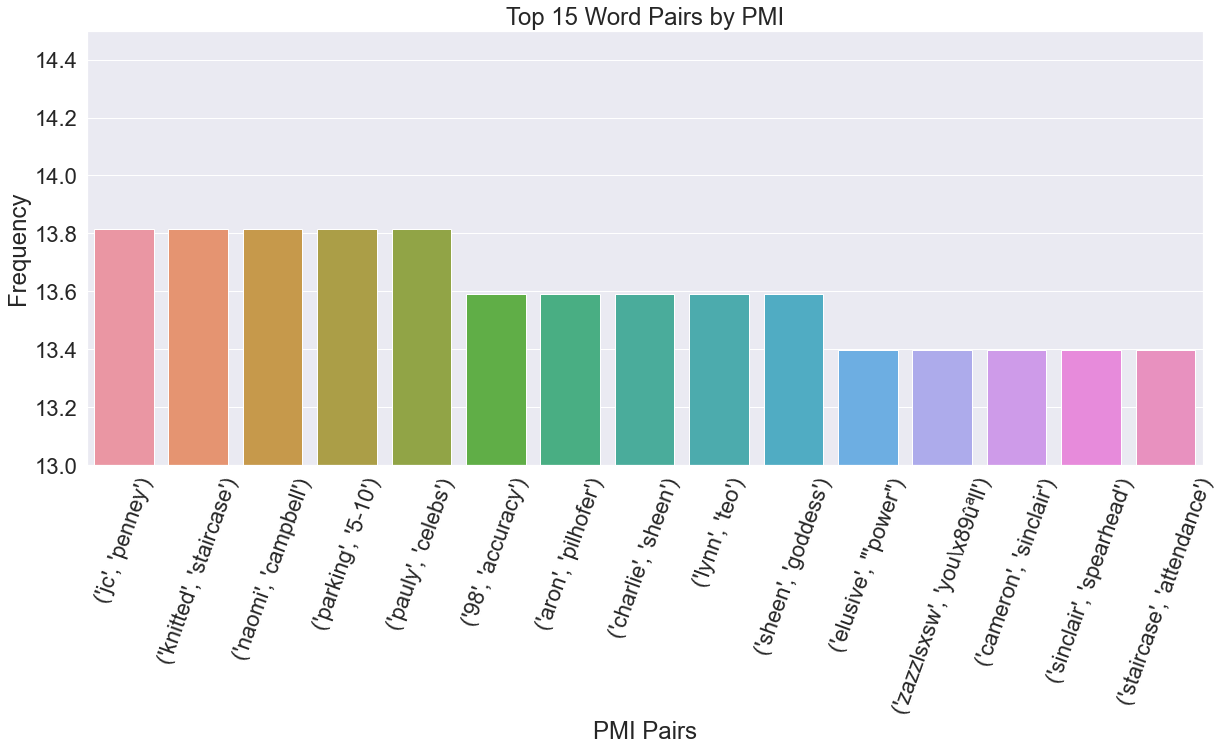

In [448]:
fig_dims = (20,8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.set(font_scale=2)
sns.set_style("darkgrid")
palette = sns.set_palette("dark")
ax = sns.barplot(x=PMI_list.head(15)['Words'], y=PMI_list.head(15)['PMI'], 
                 palette=palette)
ax.set(xlabel="PMI Pairs",ylabel="Frequency")
plt.ylim([13,14.5])
plt.ticklabel_format(style='plain',axis='y')
plt.xticks(rotation=70)
plt.title('Top 15 Word Pairs by PMI')
plt.show()

In [449]:
df1 = df
df.head()

,Tweet,Platform,Emotion,Uncertain,Negative,No Emotion,Positive
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,0,1,0,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,0,0,0,1
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,0,0,0,1
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,0,1,0,0
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,0,0,0,1


In [450]:
df1 = df1.drop(columns=['Uncertain','No Emotion'])
# Turn negative and positive columns into one column of just negatives 
# and positive.
df1 = df1[df1['Emotion'] != "No emotion toward brand or product"]
df1 = df1[df1['Emotion'] != "I can't tell"]
df1 = df1.drop(columns='Negative')
df1 = df1.rename(columns={'Positive': 'Positive_Bin'})
df1.head()

,Tweet,Platform,Emotion,Positive_Bin
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,1
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,1
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,0
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,1


In [451]:
df1.to_csv('Tweet.csv')

### Create Upsampled Data

In [452]:
df_majority = df1.loc[df1['Positive_Bin']==1]
df_minority = df1.loc[df1['Positive_Bin']==0]

In [453]:
df_minority.shape

(570, 4)

In [454]:
df_majority.shape

(2978, 4)

In [455]:
df_min_sample = resample(df_minority, replace=True, n_samples=1000, 
                         random_state=42)

In [456]:
df_maj_sample = resample(df_majority, replace=True, n_samples=2500, 
                         random_state=42)

In [457]:
df_upsampled = pd.concat([df_min_sample, df_maj_sample], axis=0)
df_upsampled.shape

(3500, 4)

In [458]:
X, y = df_upsampled['Tweet'], df_upsampled['Positive_Bin']

In [459]:
df_upsampled.to_csv('Upsampled.csv')

## Modeling

### Train/Test Split

In [460]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [461]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3548 entries, 0 to 9088
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Tweet         3548 non-null   object
 1   Platform      3191 non-null   object
 2   Emotion       3548 non-null   object
 3   Positive_Bin  3548 non-null   uint8 
dtypes: object(3), uint8(1)
memory usage: 114.3+ KB


In [462]:
y_train.value_counts(0)
y_test.value_counts(1)

1    0.683429
0    0.316571
Name: Positive_Bin, dtype: float64

### Vectorize, Lemmatize with Count Vectorizer and Tf Idf

In [526]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier

tokenizer = nltk.TweetTokenizer(preserve_case=False)

vectorizer = CountVectorizer(tokenizer=tokenizer.tokenize,
                             stop_words=stopword_list,decode_error='ignore')

In [527]:
X_train_count = vectorizer.fit_transform(X_train)
X_test_count = vectorizer.transform(X_test)

C:\Users\josep\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens [":'[", ':/', 'a-z', 'a-za-z', 'http', 'n', 'w', '‘'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


### MaxAbsScaler

In [528]:
scaler_object = MaxAbsScaler().fit(X_train_count)

In [529]:
scaler_object.transform(X_train_count)

<2625x4295 sparse matrix of type '<class 'numpy.float64'>'
	with 28229 stored elements in Compressed Sparse Row format>

In [530]:
scaler_object.transform(X_test_count)

<875x4295 sparse matrix of type '<class 'numpy.float64'>'
	with 8854 stored elements in Compressed Sparse Row format>

### Instantiate Model

In [531]:
ran_for = RandomForestClassifier(class_weight='balanced')
model = ran_for.fit(X_train_count, y_train)

In [532]:
y_hat_test = model.predict(X_test_count)

## Evaluate Models
#### 1 denotes a Positive Tweet, 0 denotes a Negative Tweet

### Random Forest with Count Vectorizer

              precision    recall  f1-score   support

           0       0.95      0.83      0.89       277
           1       0.93      0.98      0.95       598

    accuracy                           0.93       875
   macro avg       0.94      0.91      0.92       875
weighted avg       0.94      0.93      0.93       875



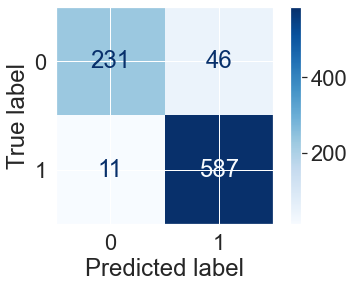

In [533]:
evaluate_model(y_test, y_hat_test, X_test_count,clf=model) 
# 1 denotes Positive Tweet

#### Basic Random Forest model performs well after preprocessing with high precision and f1-scores. 

In [534]:
tf_idf_vectorizer = TfidfVectorizer(tokenizer=tokenizer.tokenize,
                                    stop_words=stopword_list,
                                    decode_error='ignore')

In [535]:
X_train_tf_idf = tf_idf_vectorizer.fit_transform(X_train)
X_test_tf_idf = tf_idf_vectorizer.transform(X_test)
print(X_train_tf_idf.shape)
print(y_train.shape)

C:\Users\josep\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens [":'[", ':/', 'a-z', 'a-za-z', 'http', 'n', 'w', '‘'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


(2625, 4295)
(2625,)


In [536]:
from sklearn.ensemble import RandomForestClassifier

In [537]:
ran_for = RandomForestClassifier(class_weight='balanced')
model_tf_idf = ran_for.fit(X_train_tf_idf,y_train)

In [538]:
y_hat_tf_idf = model_tf_idf.predict(X_test_count)

### Random Forest with Tf-Idf Vectorizer

              precision    recall  f1-score   support

           0       0.92      0.60      0.73       277
           1       0.84      0.97      0.90       598

    accuracy                           0.86       875
   macro avg       0.88      0.79      0.82       875
weighted avg       0.87      0.86      0.85       875



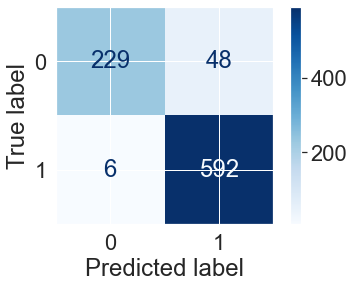

In [539]:
evaluate_model(y_test, y_hat_tf_idf, X_test_tf_idf,clf=model_tf_idf) 

### Multiple Models, CountVectorizer

Accuracy Score:  0.9348571428571428
Precision Score:  0.9206842923794712
Recall Score:  0.9899665551839465
F1 Score:  0.9540692989524577
RandomForestClassifier()   0.9348571428571428


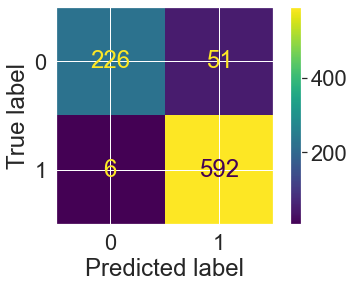

Accuracy Score:  0.7691428571428571
Precision Score:  0.7661290322580645
Recall Score:  0.9531772575250836
F1 Score:  0.849478390461997
AdaBoostClassifier()   0.7691428571428571


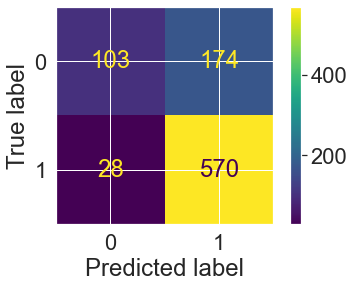

Accuracy Score:  0.776
Precision Score:  0.7563775510204082
Recall Score:  0.9916387959866221
F1 Score:  0.8581765557163531
GradientBoostingClassifier()   0.776


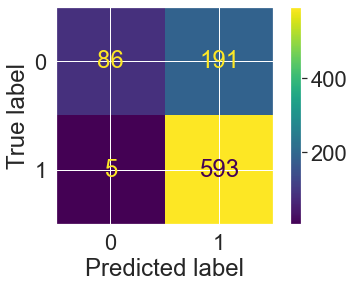

In [540]:
ran_for = RandomForestClassifier()
ada_clf = AdaBoostClassifier()
gb_clf = GradientBoostingClassifier()

models = [ran_for, ada_clf, gb_clf]

for model in models:
    single_model_opt(model, X_train_count, y_train, X_test_count, y_test)

### Multiple Models, Tf-Idf Vectorizer

Accuracy Score:  0.9291428571428572
Precision Score:  0.9161490683229814
Recall Score:  0.9866220735785953
F1 Score:  0.9500805152979066
RandomForestClassifier()   0.9291428571428572


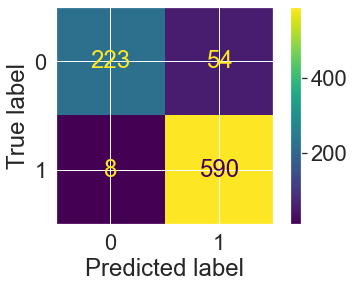

Accuracy Score:  0.7782857142857142
Precision Score:  0.7797783933518005
Recall Score:  0.9414715719063546
F1 Score:  0.8530303030303031
AdaBoostClassifier()   0.7782857142857142


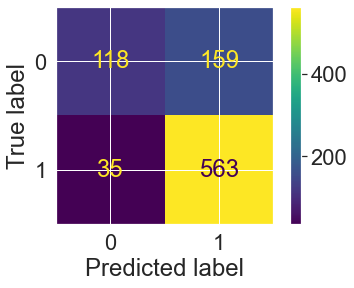

Accuracy Score:  0.7782857142857142
Precision Score:  0.7623376623376623
Recall Score:  0.9816053511705686
F1 Score:  0.858187134502924
GradientBoostingClassifier()   0.7782857142857142


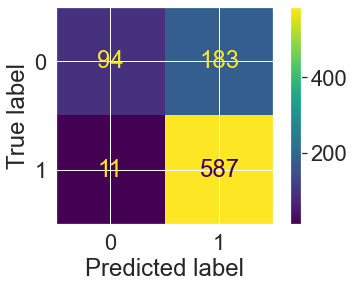

In [541]:
for model in models:
    single_model_opt(model, X_train_tf_idf, y_train, X_test_tf_idf, y_test)

In [542]:
tf_idf_vectorizer.get_feature_names()

['##sxsw',
 '#10',
 '#106',
 '#11ntc',
 '#1406-08',
 '#15slides',
 '#310409h2011',
 '#4sq',
 '#911tweets',
 '#abacus',
 '#accesssxsw',
 '#accordion',
 '#aclu',
 '#adam',
 '#addictedtotheinterwebs',
 '#adpeopleproblems',
 '#agchat',
 '#agileagency',
 '#agnerd',
 '#allhat3',
 '#alwayshavingtoplugin',
 '#amateurhour',
 '#android',
 "#android's",
 '#androidsxsw',
 '#angrybirds',
 '#annoying',
 '#app',
 '#appcircus',
 '#apple',
 "#apple's",
 '#apple_store',
 '#appleatxdt',
 '#applefanatic',
 '#appletakingoverworld',
 '#apps',
 '#appstore',
 '#art',
 '#assistivetech',
 '#at',
 '#atl',
 '#att',
 '#atx',
 '#atzip',
 '#augcomm',
 '#aus',
 '#austin',
 '#austincrowd',
 '#austinwins',
 '#ausxsw',
 '#bankinnovate',
 '#bankinnovation',
 '#barrydiller',
 '#batterykiller',
 '#battlela',
 '#bavcid',
 '#bawling',
 '#bbq',
 '#behance',
 '#bestappever',
 '#betainvites',
 '#bettercloud',
 '#bettersearch',
 '#betterthingstodo',
 '#beyondwc',
 '#bing',
 '#bizzy',
 '#blackberry',
 '#boom',
 '#booyah',
 '#brai

In [543]:
importance = pd.Series(ran_for.feature_importances_,
                       index=tf_idf_vectorizer.get_feature_names())
importance = pd.DataFrame(importance).sort_values(by=0,ascending=False)

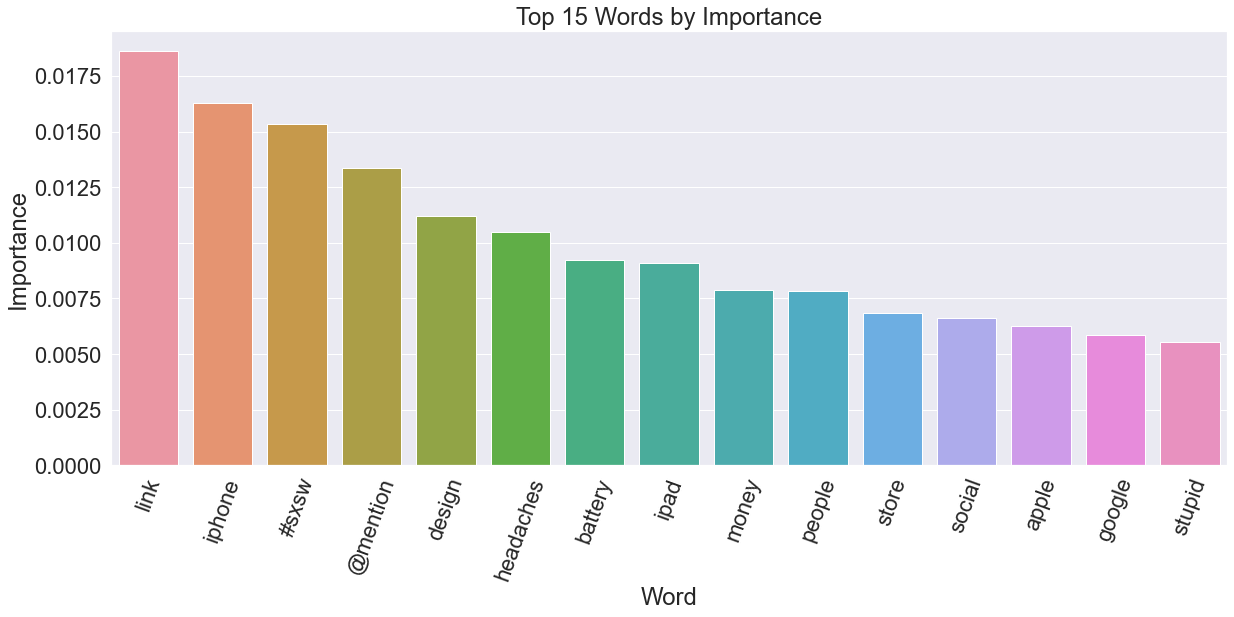

In [544]:
fig_dims = (20,8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.set(font_scale=2)
sns.set_style("darkgrid")
palette = sns.set_palette("dark")
ax = sns.barplot(x=importance.head(15).index, y=importance.head(15)[0], 
                 palette=palette)
ax.set(xlabel="Word",ylabel="Importance")
plt.ticklabel_format(style='plain',axis='y')
plt.xticks(rotation=70)
plt.title('Top 15 Words by Importance')
plt.show() 

### Pipeline and GridSearchCV

In [545]:
vectorizer = CountVectorizer()
tf_transform = TfidfTransformer(use_idf=True)

In [546]:
text_pipe = Pipeline(steps=[
    ('count_vectorizer',vectorizer),
    ('tf_transformer',tf_transform)])

In [547]:
RandomForestClassifier(class_weight='balanced')

RandomForestClassifier(class_weight='balanced')

In [548]:
full_pipe = Pipeline(steps=[
    ('text_pipe',text_pipe),
    ('clf',RandomForestClassifier(class_weight='balanced'))
])

In [549]:
X_train_pipe = text_pipe.fit_transform(X_train)

In [550]:
X_test_pipe = text_pipe.transform(X_test)

In [551]:
X_train_pipe

<2625x4256 sparse matrix of type '<class 'numpy.float64'>'
	with 44273 stored elements in Compressed Sparse Row format>

In [552]:
params = {'text_pipe__tf_transformer__use_idf':[True, False],
         'text_pipe__count_vectorizer__tokenizer':[None,tokenizer.tokenize],
         'text_pipe__count_vectorizer__stop_words':[None,stopword_list],
         'clf__criterion':['gini', 'entropy']}

In [553]:
## Make and fit grid
grid = GridSearchCV(full_pipe,params,cv=3)
grid.fit(X_train,y_train)
## Display best params
grid.best_params_

C:\Users\josep\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['http'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
C:\Users\josep\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['http'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
C:\Users\josep\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['http'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
C:\Users\josep\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with

{'clf__criterion': 'gini',
 'text_pipe__count_vectorizer__stop_words': ['now',
  'formerly',
  '‘d',
  'bottom',
  'onto',
  'due',
  'someone',
  'amongst',
  'can',
  'wherever',
  'an',
  'toward',
  'ca',
  'alone',
  'nothing',
  'where',
  'however',
  'and',
  'six',
  'without',
  "'d",
  'am',
  'me',
  'when',
  '’s',
  'their',
  'beforehand',
  'enough',
  'around',
  'amount',
  'from',
  're',
  'somehow',
  'noone',
  'that',
  'have',
  'so',
  'throughout',
  'how',
  'just',
  "'re",
  'eight',
  'others',
  'with',
  '’re',
  'full',
  'between',
  'seems',
  'could',
  'cannot',
  'next',
  'be',
  'thence',
  'empty',
  'its',
  'had',
  'hereupon',
  'anyhow',
  'nowhere',
  'been',
  'anywhere',
  'twelve',
  'these',
  'as',
  'of',
  'more',
  'whereby',
  'this',
  'otherwise',
  'still',
  'everywhere',
  'well',
  'myself',
  'anything',
  'was',
  'here',
  'mostly',
  'several',
  'afterwards',
  'least',
  'seemed',
  '‘re',
  'regarding',
  'then',
  'th

In [554]:
best_pipe = grid.best_estimator_
y_hat_test = grid.predict(X_test)

              precision    recall  f1-score   support

           0       0.94      0.85      0.89       277
           1       0.93      0.97      0.95       598

    accuracy                           0.93       875
   macro avg       0.94      0.91      0.92       875
weighted avg       0.93      0.93      0.93       875



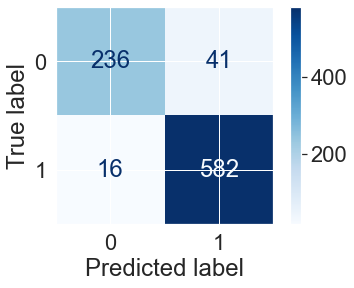

In [555]:
evaluate_model(y_test,y_hat_test,X_test,best_pipe)

In [556]:
X_train_pipe.shape

(2625, 4256)

### Bigram Frequency

In [557]:
features = text_pipe.named_steps['count_vectorizer'].get_feature_names()
features[:10]

['000', '02', '03', '0310apple', '08', '10', '100', '100s', '101', '106']

In [558]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
tweet_finder = nltk.BigramCollocationFinder.from_words(clean_lemmatized_tokenz)
tweets_scored = tweet_finder.score_ngrams(bigram_measures.raw_freq)

In [559]:
bigram1 = pd.DataFrame(tweets_scored, columns=['Words','Freq'])
bigram1.head()

,Words,Freq
0,"(apple, store)",0.006920
1,"(social, network)",0.005277
2,"(new, social)",0.004837
3,"(google, launch)",0.003912
4,"(link, google)",0.003877


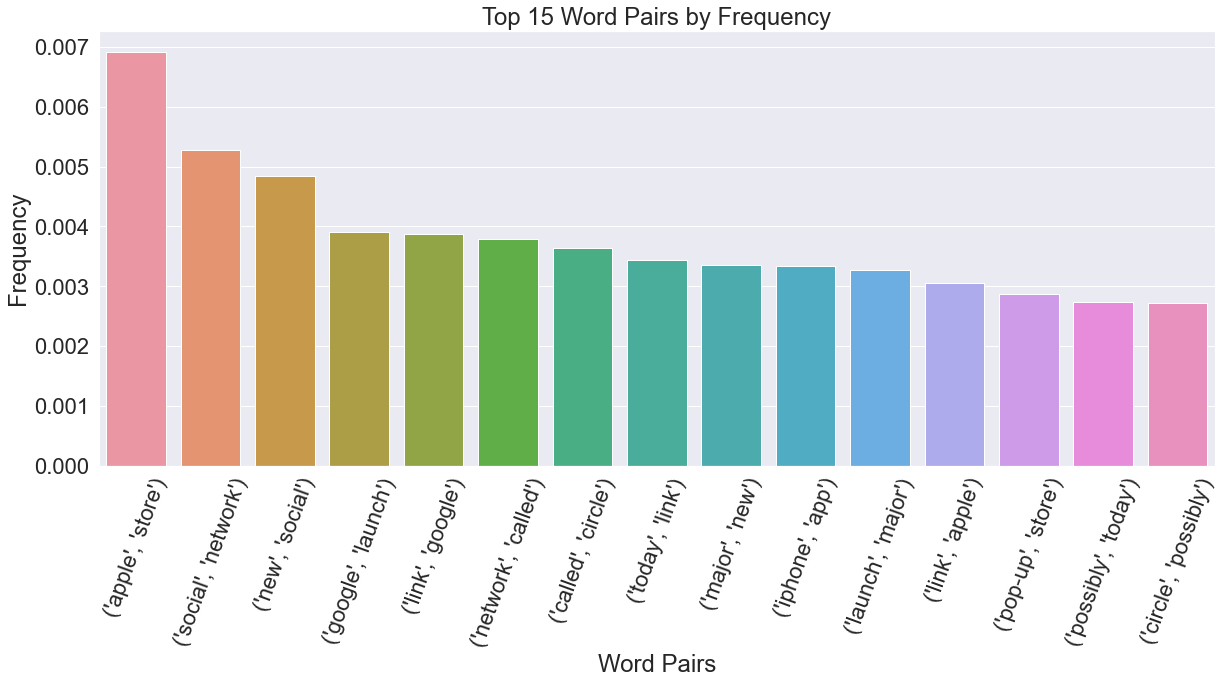

In [560]:
fig_dims = (20,8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.set(font_scale=2)
sns.set_style("darkgrid")
palette = sns.set_palette("dark")
ax = sns.barplot(x=bigram1.head(15)['Words'], y=bigram1.head(15)['Freq'], 
                 palette=palette)
ax.set(xlabel="Word Pairs",ylabel="Frequency")
plt.ticklabel_format(style='plain',axis='y')
plt.xticks(rotation=70)
plt.title('Top 15 Word Pairs by Frequency')
plt.show() 

## Deep NLP using Keras NN (binary)

In [561]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers, optimizers

In [562]:
model = 0

In [563]:
tweets = df_upsampled['Tweet']
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(tweets)
sequences = tokenizer.texts_to_sequences(tweets)
print('sequences type: ' , type(sequences))

sequences type:  <class 'list'>


In [633]:
one_hot_results = tokenizer.texts_to_matrix(tweets, mode='binary')
print('one_hot_results type:', type(one_hot_results))
one_hot_results = np.asarray(one_hot_results)

one_hot_results type: <class 'numpy.ndarray'>


In [634]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index)) 

Found 4816 unique tokens.


In [635]:
print('Dimensions of our coded results:', np.shape(one_hot_results)) 

Dimensions of our coded results: (3500, 10000)


In [636]:
y = df_upsampled['Positive_Bin']

In [637]:
y = np.asarray(y)

In [638]:
print(y.shape)
print(one_hot_results.shape)

(3500,)
(3500, 10000)


In [639]:
print(len(y))

3500


In [640]:
import random

In [641]:
random.seed(42)
test_index = list(random.sample(range(1,3200),2000))
print(test)
print(train)

test = np.asarray(one_hot_results[test_index])
train = np.delete(one_hot_results, test_index, 0) 

label_test = y[test_index]
label_train = np.delete(y, test_index, 0)

print('Test label shape:', np.shape(label_test))
print('Train label shape:', np.shape(label_train))
print('Test shape:', np.shape(test))
print('Train shape:', np.shape(train))

[[0. 1. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
[[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
Test label shape: (2000,)
Train label shape: (1500,)
Test shape: (2000, 10000)
Train shape: (1500, 10000)


In [642]:
# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(list(X))
# sequences = tokenizer.texts_to_sequences(X)
# X = sequence.pad_sequences(sequences,maxlen=100)

In [643]:
tokenizer.word_counts

OrderedDict([('at', 1127),
             ('sxsw', 3630),
             ('tapworthy', 44),
             ('ipad', 1213),
             ('design', 89),
             ('headaches', 41),
             ('avoiding', 3),
             ('the', 1847),
             ('pitfalls', 3),
             ('of', 753),
             ('new', 357),
             ('challenges', 3),
             ('rt', 1000),
             ('mention', 2312),
             ('part', 12),
             ('journalsim', 5),
             ('is', 883),
             ('support', 15),
             ('democracy', 5),
             ('yes', 47),
             ('informed', 5),
             ('populous', 5),
             ('as', 128),
             ('a', 983),
             ('focus', 7),
             ('does', 40),
             ('not', 232),
             ('that', 249),
             ('newsapps', 17),
             ('fuck', 8),
             ('iphone', 763),
             ('ubersocial', 23),
             ('for', 1015),
             ('now', 151),
             ('in', 711

In [644]:
print(type(X),X.shape)
print(type(y),y.shape)

<class 'pandas.core.series.Series'> (3500,)
<class 'numpy.ndarray'> (3500,)


In [646]:
print(type(X),X.shape)
print(type(y),y.shape)

<class 'pandas.core.series.Series'> (3500,)
<class 'numpy.ndarray'> (3500,)


In [653]:
# Initialize a sequential model
model = []
model = models.Sequential()
# Two layers with relu activation
model.add(layers.Dense(32, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

In [654]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_10 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 17        
Total params: 320,577
Trainable params: 320,577
Non-trainable params: 0
_________________________________________________________________


In [655]:
train.shape

(1500, 10000)

In [656]:
label_train.shape

(1500,)

In [657]:
history = model.fit(train, label_train, batch_size=32, epochs=20, verbose=2, 
                    validation_split=.2)

Epoch 1/20
38/38 - 1s - loss: 0.6209 - acc: 0.6825 - val_loss: 0.3272 - val_acc: 1.0000
Epoch 2/20
38/38 - 0s - loss: 0.4691 - acc: 0.7417 - val_loss: 0.2253 - val_acc: 0.9900
Epoch 3/20
38/38 - 0s - loss: 0.2875 - acc: 0.9117 - val_loss: 0.1825 - val_acc: 0.9600
Epoch 4/20
38/38 - 0s - loss: 0.1253 - acc: 0.9742 - val_loss: 0.1430 - val_acc: 0.9467
Epoch 5/20
38/38 - 0s - loss: 0.0542 - acc: 0.9933 - val_loss: 0.1577 - val_acc: 0.9233
Epoch 6/20
38/38 - 0s - loss: 0.0259 - acc: 0.9983 - val_loss: 0.1506 - val_acc: 0.9167
Epoch 7/20
38/38 - 0s - loss: 0.0144 - acc: 1.0000 - val_loss: 0.1510 - val_acc: 0.9167
Epoch 8/20
38/38 - 0s - loss: 0.0086 - acc: 1.0000 - val_loss: 0.1548 - val_acc: 0.9133
Epoch 9/20
38/38 - 0s - loss: 0.0060 - acc: 1.0000 - val_loss: 0.1553 - val_acc: 0.9167
Epoch 10/20
38/38 - 0s - loss: 0.0044 - acc: 1.0000 - val_loss: 0.1816 - val_acc: 0.9067
Epoch 11/20
38/38 - 0s - loss: 0.0033 - acc: 1.0000 - val_loss: 0.1671 - val_acc: 0.9100
Epoch 12/20
38/38 - 0s - loss:

## Deep NLP using Word2Vec

In [658]:
from nltk import word_tokenize

In [659]:
data = df_upsampled['Tweet'].map(word_tokenize)

In [660]:
data[:10]

1749    [At, #, sxsw, #, tapworthy, iPad, Design, Head...
6436    [RT, @, mention, Part, of, Journalsim, is, the...
3838    [Fuck, the, iphone, !, RT, @, mention, New, #,...
1770    [#, SXSW, 2011, :, Novelty, of, iPad, news, ap...
1062    [New, #, SXSW, rule, :, no, more, ooing, and, ...
324     [Overheard, at, #, sxsw, interactive, :, &, qu...
1944    [#, virtualwallet, #, sxsw, no, NFC, in, #, ip...
7201    [#, SXSW, a, tougher, crowd, than, Colin, Quin...
3159    [Why, is, wifi, working, on, my, laptop, but, ...
4631    [Is, starting, to, think, my, #, blackberry, i...
Name: Tweet, dtype: object

In [661]:
model_W2V = Word2Vec(data, size =100, window=5, min_count=1, workers=4)

2020-12-22 19:57:06,290 : INFO : collecting all words and their counts
2020-12-22 19:57:06,291 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-12-22 19:57:06,306 : INFO : collected 5920 word types from a corpus of 86715 raw words and 3500 sentences
2020-12-22 19:57:06,307 : INFO : Loading a fresh vocabulary
2020-12-22 19:57:06,320 : INFO : effective_min_count=1 retains 5920 unique words (100% of original 5920, drops 0)
2020-12-22 19:57:06,320 : INFO : effective_min_count=1 leaves 86715 word corpus (100% of original 86715, drops 0)
2020-12-22 19:57:06,342 : INFO : deleting the raw counts dictionary of 5920 items
2020-12-22 19:57:06,343 : INFO : sample=0.001 downsamples 52 most-common words
2020-12-22 19:57:06,344 : INFO : downsampling leaves estimated 56808 word corpus (65.5% of prior 86715)
2020-12-22 19:57:06,356 : INFO : estimated required memory for 5920 words and 100 dimensions: 7696000 bytes
2020-12-22 19:57:06,357 : INFO : resetting layer weights
2

In [662]:
model_W2V.train(data,total_examples=model_W2V.corpus_count, epochs=10)

2020-12-22 19:57:07,654 : WARNING : Effective 'alpha' higher than previous training cycles
2020-12-22 19:57:07,655 : INFO : training model with 4 workers on 5920 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=5
2020-12-22 19:57:07,695 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-12-22 19:57:07,700 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-12-22 19:57:07,702 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-12-22 19:57:07,703 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-12-22 19:57:07,703 : INFO : EPOCH - 1 : training on 86715 raw words (56912 effective words) took 0.0s, 1408730 effective words/s
2020-12-22 19:57:07,739 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-12-22 19:57:07,741 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-12-22 19:57:07,745 : INFO : worker thread finished; awaiting finish of 1 mo

(568112, 867150)

In [663]:
wv = model_W2V.wv

In [664]:
wv.most_similar(positive='phone')

2020-12-22 19:57:08,134 : INFO : precomputing L2-norms of word weight vectors


[('dawdled', 0.9737276434898376),
 ('tweeted', 0.9662427306175232),
 ('3g', 0.9591308832168579),
 ('Beats', 0.9574084281921387),
 ('cases', 0.9564257264137268),
 ('lust', 0.954750657081604),
 ('wjchat', 0.9545691013336182),
 ('correcting', 0.9536786675453186),
 ('curse', 0.9531481266021729),
 ('words', 0.9525964856147766)]

In [665]:
wv['help']

array([-6.45474717e-02,  8.33753124e-02,  1.01433106e-01,  1.84702054e-01,
        1.24648370e-01,  1.44534826e-01,  1.95535898e-01,  3.32259804e-01,
        1.69485271e-01,  9.84343663e-02,  2.68179655e-01, -7.09125251e-02,
       -2.32185069e-02,  3.42252165e-01, -1.46325678e-01, -4.17944323e-03,
       -3.08119263e-02, -1.47175074e-01, -4.58924398e-02,  3.62276822e-01,
        1.83033198e-01, -1.14861717e-02, -2.29902133e-01, -2.85449605e-02,
        2.12223426e-01,  7.23858476e-02, -3.14931244e-01,  2.51128137e-01,
        3.16947922e-02, -1.74161538e-01, -1.13570601e-01, -2.13714108e-01,
        3.05798021e-04,  3.25136125e-01,  1.15869761e-01,  1.32141396e-01,
       -1.04895756e-01, -3.01056560e-02, -3.20330650e-01,  5.27168401e-02,
       -9.89334658e-02, -3.43139544e-02, -1.94885597e-01,  2.01208889e-01,
        1.57899633e-01,  1.61257312e-01, -1.08497940e-01,  2.67968982e-01,
       -1.40484616e-01,  2.34758854e-02, -3.69767457e-01, -6.50556711e-03,
       -5.86667433e-02,  

In [666]:
wv.vectors

array([[-1.025065  ,  0.36512864,  0.18380004, ...,  0.8596125 ,
         0.37141412,  0.6184928 ],
       [-0.09678259,  0.50694585,  0.49173787, ...,  0.823572  ,
         0.646872  ,  0.20836489],
       [-0.9487454 ,  0.9035805 , -0.24147403, ...,  0.7165677 ,
         0.43897453,  0.20222358],
       ...,
       [-0.03057944,  0.01372964,  0.00384543, ...,  0.04745195,
         0.05498523,  0.01907661],
       [-0.01054236, -0.01948454,  0.01659136, ..., -0.02013808,
         0.01280252, -0.01673194],
       [ 0.00677707,  0.01249733,  0.01498331, ...,  0.02493414,
         0.03569862, -0.01226232]], dtype=float32)

In [667]:
df_tech = pd.DataFrame(wv.most_similar(positive=['technology']))

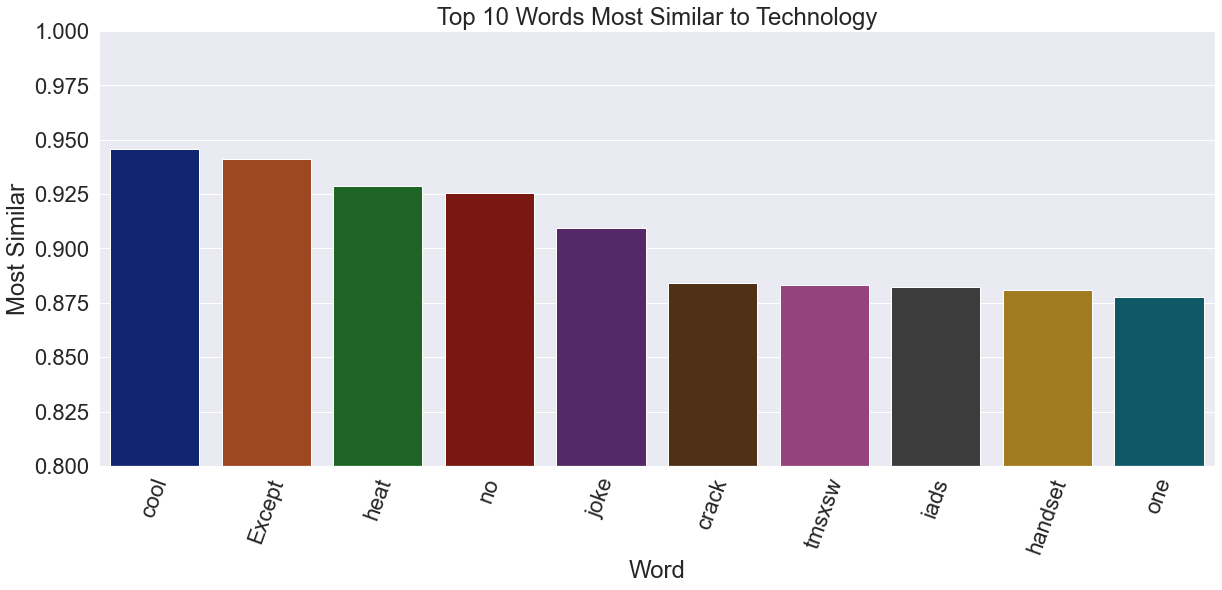

In [668]:
fig_dims = (20,8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.set(font_scale=2)
sns.set_style("darkgrid")
palette = sns.set_palette("dark")
ax = sns.barplot(x=df_tech.head(10)[0], y=df_tech.head(10)[1], 
                 palette=palette)
ax.set(xlabel="Word",ylabel="Most Similar")
plt.ticklabel_format(style='plain',axis='y')
plt.ylim(.8,1)
plt.xticks(rotation=70)
plt.title('Top 10 Words Most Similar to Technology')
plt.show()

In [669]:
df_google = pd.DataFrame(wv.most_similar(positive=['google']))
df_google

,0,1
0,Thats,0.934094
1,maps,0.921220
2,doodle,0.917917
3,mobile,0.905687
4,machine,0.901329
5,5.0,0.901321
6,ex,0.898733
7,150,0.897714
8,million,0.894708
9,Wave,0.890735


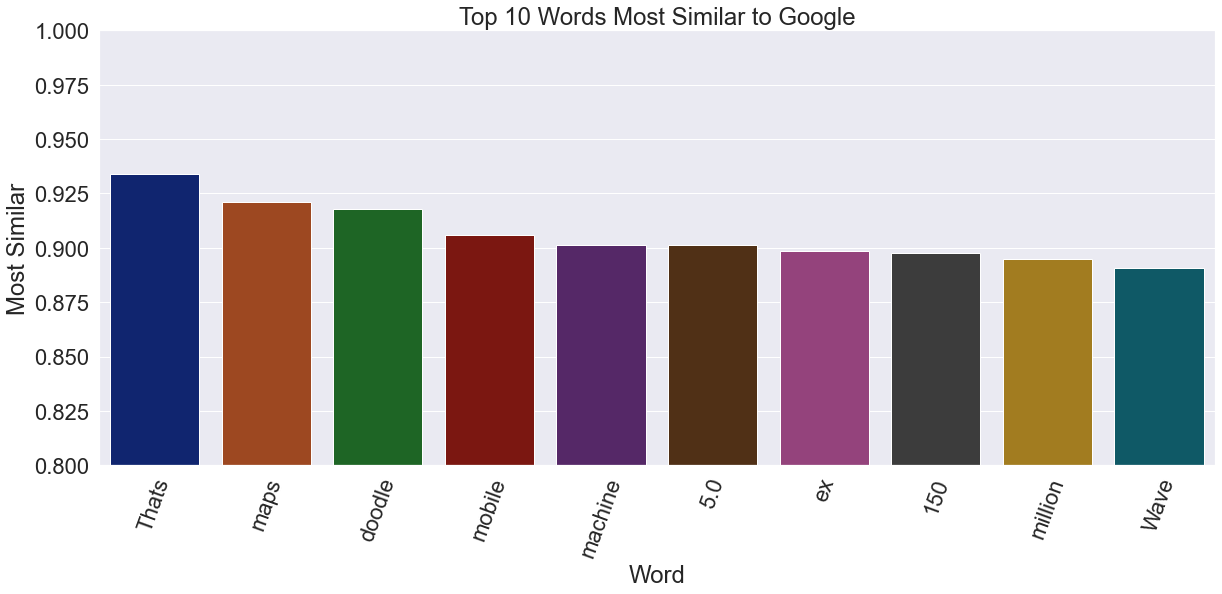

In [670]:
fig_dims = (20,8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.set(font_scale=2)
sns.set_style("darkgrid")
palette = sns.set_palette("dark")
ax = sns.barplot(x=df_google.head(10)[0], y=df_google.head(10)[1], 
                 palette=palette)
ax.set(xlabel="Word",ylabel="Most Similar")
plt.ticklabel_format(style='plain',axis='y')
plt.ylim(.8,1)
plt.xticks(rotation=70)
plt.title('Top 10 Words Most Similar to Google')
plt.show()

In [671]:
df_apple = pd.DataFrame(wv.most_similar(positive=['apple']))
df_apple

,0,1
0,comes,0.919353
1,xD,0.894253
2,flash,0.862975
3,fundraising,0.846550
4,scheduling,0.841430
5,downstairs,0.836992
6,Ave,0.836069
7,Where,0.827376
8,temp,0.826329
9,crazyco,0.825343


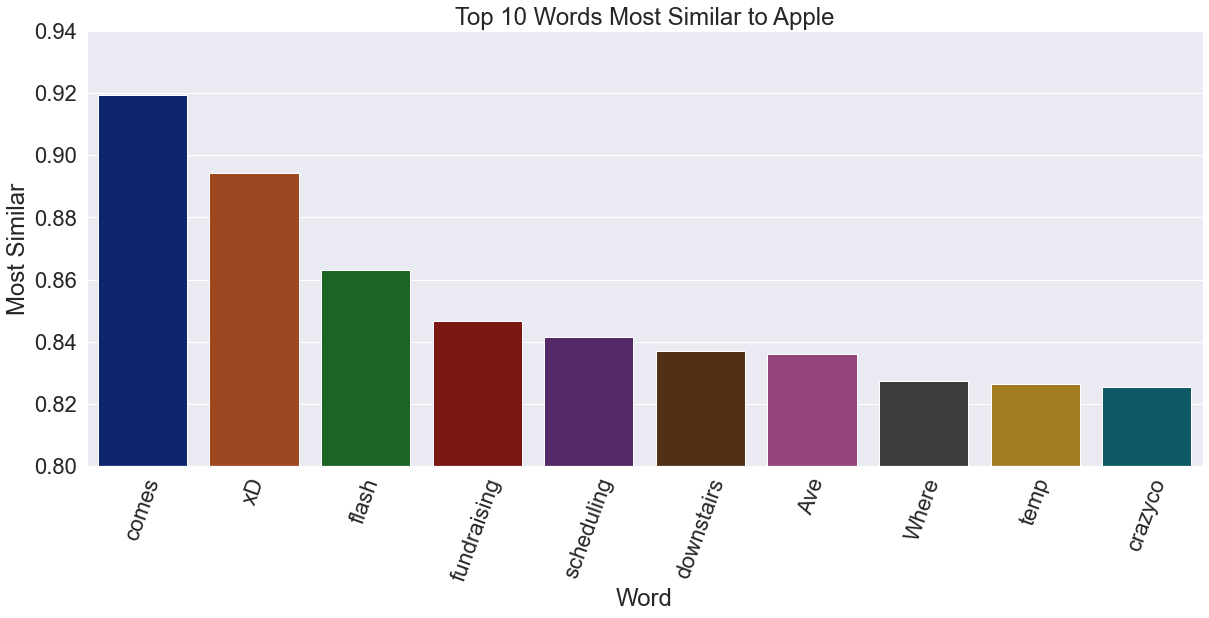

In [672]:
fig_dims = (20,8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.set(font_scale=2)
sns.set_style("darkgrid")
palette = sns.set_palette("dark")
ax = sns.barplot(x=df_apple.head(10)[0], y=df_apple.head(10)[1], palette=palette)
ax.set(xlabel="Word",ylabel="Most Similar")
plt.ticklabel_format(style='plain',axis='y')
plt.ylim(.8,.94)
plt.xticks(rotation=70)
plt.title('Top 10 Words Most Similar to Apple')
plt.show()

In [673]:
import nltk
nltk.download('vader_lexicon')

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn import preprocessing
from keras.preprocessing.text import Tokenizer
from keras import models
from keras import layers
from keras import optimizers

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\josep\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Keras NN Multiple Classification

In [674]:
df = pd.read_csv('Tweet.csv')
df_up = pd.read_csv('Upsampled.csv')

In [675]:
df = df.drop(columns='Unnamed: 0')

In [676]:
df.head(5) # normal 

,Tweet,Platform,Emotion,Positive_Bin
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,1
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,1
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,0
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,1


In [677]:
df_up = df_up.drop(columns='Unnamed: 0')

In [678]:
df_up.head(5) # upsampled for increased number of negative tweets

,Tweet,Platform,Emotion,Positive_Bin
0,At #sxsw #tapworthy iPad Design Headaches - av...,iPad,Negative emotion,0
1,RT @mention Part of Journalsim is the support ...,NaN,Negative emotion,0
2,Fuck the iphone! RT @mention New #UberSocial f...,iPhone,Negative emotion,0
3,#SXSW 2011: Novelty of iPad news apps fades fa...,iPad,Negative emotion,0
4,New #SXSW rule: no more ooing and ahing over y...,iPad,Negative emotion,0


In [679]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3548 entries, 0 to 3547
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Tweet         3548 non-null   object
 1   Platform      3191 non-null   object
 2   Emotion       3548 non-null   object
 3   Positive_Bin  3548 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 111.0+ KB


In [680]:
df_up.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Tweet         3500 non-null   object
 1   Platform      3171 non-null   object
 2   Emotion       3500 non-null   object
 3   Positive_Bin  3500 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 109.5+ KB


In [681]:
df_up['Positive_Bin'].value_counts()

1    2500
0    1000
Name: Positive_Bin, dtype: int64

In [682]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [683]:
sid = SentimentIntensityAnalyzer()

In [684]:
df_up['scores'] = df_up['Tweet'].apply(lambda review:sid.polarity_scores(review))

In [685]:
df_up['compound'] = df_up['scores'].apply(lambda d:d['compound'])

In [686]:
df_up['comp_score'] = df_up['compound'].apply(lambda score: 1 
                                              if score >= 0 else 0)

In [687]:
df_up.head()

,Tweet,Platform,Emotion,Positive_Bin,scores,compound,comp_score
0,At #sxsw #tapworthy iPad Design Headaches - av...,iPad,Negative emotion,0,"{'neg': 0.153, 'neu': 0.764, 'pos': 0.083, 'co...",-0.2732,0
1,RT @mention Part of Journalsim is the support ...,NaN,Negative emotion,0,"{'neg': 0.0, 'neu': 0.63, 'pos': 0.37, 'compou...",0.8796,1
2,Fuck the iphone! RT @mention New #UberSocial f...,iPhone,Negative emotion,0,"{'neg': 0.166, 'neu': 0.834, 'pos': 0.0, 'comp...",-0.5848,0
3,#SXSW 2011: Novelty of iPad news apps fades fa...,iPad,Negative emotion,0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,1
4,New #SXSW rule: no more ooing and ahing over y...,iPad,Negative emotion,0,"{'neg': 0.083, 'neu': 0.83, 'pos': 0.087, 'com...",0.0258,1


In [688]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

In [689]:
accuracy_score(df_up['Positive_Bin'],df_up['comp_score'])

0.7537142857142857

In [690]:
print(classification_report(df_up['Positive_Bin'],df_up['comp_score']))

              precision    recall  f1-score   support

           0       0.61      0.39      0.47      1000
           1       0.79      0.90      0.84      2500

    accuracy                           0.75      3500
   macro avg       0.70      0.64      0.66      3500
weighted avg       0.74      0.75      0.73      3500



In [691]:
confusion_matrix(df_up['Positive_Bin'],df_up['comp_score'])

array([[ 389,  611],
       [ 251, 2249]], dtype=int64)

In [695]:
full_df = pd.read_csv('Full_DF')

In [696]:
full_df.head()

,Unnamed: 0,Tweet,Platform,Emotion,Uncertain,Negative,No Emotion,Positive
0,0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,0,1,0,0
1,1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,0,0,0,1
2,2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,0,0,0,1
3,3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,0,1,0,0
4,4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,0,0,0,1


In [697]:
full_df = full_df.drop(columns='Unnamed: 0')

In [698]:
full_df.head(10)
full_df = full_df.dropna()

In [699]:
tweets = full_df['Tweet']
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(tweets)
sequences = tokenizer.texts_to_sequences(tweets)
print('sequences type: ' , type(sequences))

sequences type:  <class 'list'>


In [700]:
one_hot_results = tokenizer.texts_to_matrix(tweets, mode='binary')
print('one_hot_results type:', type(one_hot_results))

one_hot_results type: <class 'numpy.ndarray'>


In [701]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index)) 

Found 5963 unique tokens.


In [702]:
# Our coded data
print('Dimensions of our coded results:', np.shape(one_hot_results)) 

Dimensions of our coded results: (3291, 5000)


In [703]:
print(y.shape)
print(one_hot_results.shape)

(3500,)
(3291, 5000)


In [704]:
emotion = full_df['Emotion']

# Initialize
le = preprocessing.LabelEncoder() 
le.fit(emotion)
print('Original class labels:')
print(list(le.classes_))
print('\n')
emotion_cat = le.transform(emotion)  

# If you wish to retrieve the original descriptive labels post production
# list(le.inverse_transform([0, 1, 3, 3, 0, 6, 4])) 

print('New product labels:')
print(emotion_cat)
print('\n')

# Each row will be all zeros except for the category for that observation 
print('One hot labels; 4 binary columns, one for each of the categories.') 
product_onehot = to_categorical(emotion_cat)
print(product_onehot)
print('\n')

print('One hot labels shape:')
print(np.shape(product_onehot))

Original class labels:
["I can't tell", 'Negative emotion', 'No emotion toward brand or product', 'Positive emotion']


New product labels:
[1 3 3 ... 1 3 3]


One hot labels; 4 binary columns, one for each of the categories.
[[0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 ...
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


One hot labels shape:
(3291, 4)


In [705]:
random.seed(123)
test_index = random.sample(range(1,3200), 1500)

test = one_hot_results[test_index]
train = np.delete(one_hot_results, test_index, 0)

label_test = product_onehot[test_index]
label_train = np.delete(product_onehot, test_index, 0)

print('Test label shape:', np.shape(label_test))
print('Train label shape:', np.shape(label_train))
print('Test shape:', np.shape(test))
print('Train shape:', np.shape(train))

Test label shape: (1500, 4)
Train label shape: (1791, 4)
Test shape: (1500, 5000)
Train shape: (1791, 5000)


In [706]:
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential

In [707]:
# embedding_size = 128
# model.add(Embedding(embedding_size))
# model.add(Dense(16,input_dim=2, activation='relu'))
# model.add(LSTM(8,input_dim=2, activation='relu'))
# model.add(Dense(2, activation='sigmoid'))
# model.compile(loss='binary_crossentropy',
#               optimizer='adam',
#               metrics=['precision'])
# model.summary()

In [708]:
# Initialize a sequential model
model = models.Sequential()
# Two layers with relu activation
model.add(layers.Dense(50, activation='relu', input_shape=(5000,)))
model.add(layers.Dense(25, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

In [709]:
history = model.fit(train,
                    label_train,
                    epochs=20,
                    batch_size=32,
                    validation_split=.2)

Epoch 1/20
45/45 [==============================] - 1s 7ms/step - loss: 1.1695 - acc: 0.6485 - val_loss: 0.6996 - val_acc: 0.8050
Epoch 2/20
45/45 [==============================] - 0s 3ms/step - loss: 0.5611 - acc: 0.8142 - val_loss: 0.5826 - val_acc: 0.8050
Epoch 3/20
45/45 [==============================] - 0s 3ms/step - loss: 0.3651 - acc: 0.8366 - val_loss: 0.5530 - val_acc: 0.8189
Epoch 4/20
45/45 [==============================] - 0s 3ms/step - loss: 0.2030 - acc: 0.9529 - val_loss: 0.5592 - val_acc: 0.8273
Epoch 5/20
45/45 [==============================] - 0s 3ms/step - loss: 0.1422 - acc: 0.9585 - val_loss: 0.6293 - val_acc: 0.8217
Epoch 6/20
45/45 [==============================] - 0s 3ms/step - loss: 0.0948 - acc: 0.9664 - val_loss: 0.6571 - val_acc: 0.8245
Epoch 7/20
45/45 [==============================] - 0s 3ms/step - loss: 0.0491 - acc: 0.9907 - val_loss: 0.6944 - val_acc: 0.8106
Epoch 8/20
45/45 [==============================] - 0s 3ms/step - loss: 0.0414 - acc: 0.98

In [356]:
history_dict = history.history

In [357]:
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

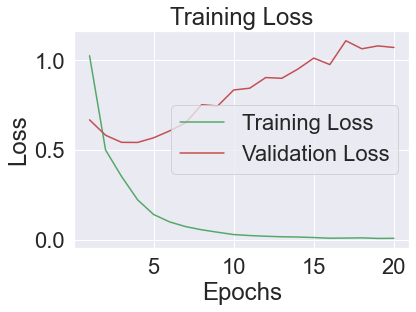

In [377]:
history_dict = history.history
loss_values = history_dict['loss']
loss_valid = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'g', label='Training Loss')
plt.plot(epochs, loss_valid, 'r', label='Validation Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

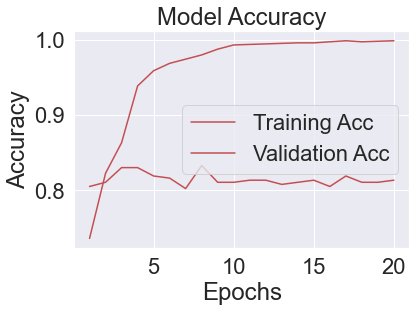

In [374]:
# Plot the training accuracy vs the number of epochs

acc_values = history_dict['acc'] 
acc_valid = history_dict['val_acc'] 

plt.figure()

plt.plot(epochs, acc_values, 'r', label='Training Acc')
plt.plot(epochs, acc_valid, 'r', label='Validation Acc')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='right')
plt.show()

In [361]:
# Output (probability) predictions for the test set 
y_hat_test = model.predict(test) 

In [362]:
# Print the loss and accuracy for the training set 
results_train = model.evaluate(train, label_train)
results_train

56/56 [==============================] - 0s 1ms/step - loss: 0.2201 - acc: 0.9615


[0.2201032042503357, 0.9614740610122681]

In [363]:
results_test = model.evaluate(test, label_test)
results_test # model predicts on the test data with 81% accuracy. 

47/47 [==============================] - 0s 1ms/step - loss: 1.0992 - acc: 0.8133


[1.0992096662521362, 0.8133333325386047]